In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), os.pardir)))
from target_assign_agent import IQLAgent, RuleAgent
from target_assign_env import raw_env

In [2]:
env = raw_env(dict(min_drones=20, possible_level=[0, 0.1, 0.4, 0.8], threat_dist=[0.15, 0.35, 0.35, 0.15]))
env.reset()
state_dim = env.state().shape[0]
action_dim = env.action_space(env.agents[0]).n

a20_ckpt = "checkpoints/checkpoint_episode_58000.pth"
a16_ckpt = "checkpoint_A16.pth"

rule_agent = RuleAgent(num_threats=20)
a20_agent = IQLAgent(state_dim, action_dim)
a20_agent.load_checkpoint(a20_ckpt)
a16_agent = IQLAgent(state_dim, action_dim)
a16_agent.load_checkpoint(a16_ckpt)

Checkpoint loaded from episode 58000
Checkpoint loaded from episode 882000


882000

In [3]:
def inference_and_collect_data(env, trained_agent, num_episodes=100):
    collected_data = []

    for episode in range(num_episodes):
        env.reset()
        episode_data = {
            "possible_level": env.possible_level.copy(),
            "threat_levels": env.threat_levels.copy(),
            "actual_threats": env.actual_threats.copy(),
        }

        for i, agent in enumerate(env.agents):
            state, _, te, tr, _ = env.last()
            action_mask = env.action_mask(agent)
            action = trained_agent.select_action(state, action_mask)
            env.step(action)

        _, reward, _, _, info = env.last()
        episode_data["assignments"] = env.actual_allocation.copy()
        episode_data["final_reward"] = reward
        episode_data["coverage"] = info["coverage"]
        episode_data["threat_destroyed"] = info["threat_destroyed"]
        episode_data["drone_lost"] = info["drone_lost"]
        episode_data["num_remaining_threat"] = info["num_remaining_threat"]
        episode_data["num_actual_threat"] = env.num_actual_threat
        episode_data["drone_cost"] = env.drone_cost.copy()

        remaining_threats = ~env.eliminated_threats & env.actual_threats
        episode_data["remaining_threat_levels"] = env.threat_levels[remaining_threats]
        episode_data["remaining_threat_positions"] = np.where(remaining_threats)[0]

        covered = env.current_allocation > 0
        destroyed = env.eliminated_threats
        actual_threats = env.actual_threats

        episode_data["coverage_destroy_relation"] = {
            "covered_destroyed": np.sum(covered & destroyed & actual_threats),
            "covered_not_destroyed": np.sum(covered & ~destroyed & actual_threats),
            "not_covered_destroyed": 0,
            "not_covered_not_destroyed": np.sum(~covered & actual_threats),
        }

        # 按威胁度计算打击成功率
        threat_levels = np.unique(env.threat_levels)
        success_rates = {}
        for level in threat_levels:
            mask = (env.threat_levels == level) & actual_threats
            if np.sum(mask) > 0:
                success_rates[level] = np.mean(destroyed[mask])
            else:
                success_rates[level] = None
        episode_data["success_rates_by_threat"] = success_rates

        collected_data.append(episode_data)

    return collected_data

In [4]:
def analyze_assignment_strategy(collected_data):
    # 1. 平均奖励和覆盖率
    rewards = [episode['final_reward'] for episode in collected_data]
    coverages = [episode['coverage'] for episode in collected_data]
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(rewards, bins=20)
    plt.title('Distribution of Final Rewards')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(coverages, bins=20)
    plt.title('Distribution of Coverage')
    plt.xlabel('Coverage')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    print(f"Average Reward: {np.mean(rewards):.2f}")
    print(f"Average Coverage: {np.mean(coverages):.2f}")

    # 2. 威胁等级与分配关系
    all_threat_levels = []
    all_assignments = []
    for episode in collected_data:
        all_threat_levels.extend(episode['threat_levels'])
        all_assignments.extend(episode['assignments'])
    
    df = pd.DataFrame({'Threat Level': all_threat_levels, 'Assignment': all_assignments})
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Threat Level', y='Assignment', data=df)
    plt.title('Distribution of Assignments by Threat Level')
    plt.show()

    # 3. 威胁摧毁率分析
    threats_destroyed = [episode['threat_destroyed'] for episode in collected_data]
    drones_lost = [episode['drone_lost'] for episode in collected_data]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(drones_lost, threats_destroyed)
    plt.title('Threats Destroyed vs Drones Lost')
    plt.xlabel('Drones Lost')
    plt.ylabel('Threats Destroyed')
    plt.show()

    # 4. 剩余威胁分析
    remaining_threats = [episode['num_remaining_threat'] for episode in collected_data]
    
    plt.figure(figsize=(10, 6))
    plt.hist(remaining_threats, bins=20)
    plt.title('Distribution of Remaining Threats')
    plt.xlabel('Remaining Threat')
    plt.ylabel('Frequency')
    plt.show()

    # 5. 分配策略热图
    # avg_assignments = np.mean([np.bincount(episode['assignments'], minlength=20) for episode in collected_data], axis=0)
    avg_assignments = np.mean([episode['assignments'] for episode in collected_data], axis=0)
    avg_threat_levels = np.mean([episode['threat_levels'] for episode in collected_data], axis=0)
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(np.vstack((avg_threat_levels, avg_assignments)), 
                cmap='YlOrRd', annot=True, fmt='.2f')
    plt.title('Average Threat Levels and Assignments')
    plt.ylabel('Threat Level | Assignments')
    plt.xlabel('Threat Position')
    plt.show()

    # 6. 剩余威胁数量的分布
    all_remaining_counts = [len(episode["remaining_threat_levels"]) for episode in collected_data]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(all_remaining_counts, kde=True)
    plt.title("Distribution of Remaining Threat Counts")
    plt.xlabel("Number of Remaining Threats")
    plt.ylabel("Frequency")
    plt.show()

    # 7. 剩余威胁等级的分布
    all_remaining_levels = [level for episode in collected_data for level in episode["remaining_threat_levels"]]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(all_remaining_levels, kde=True)
    plt.title("Distribution of Remaining Threat Levels")
    plt.xlabel("Threat Level")
    plt.ylabel("Frequency")
    plt.show()

    # 8. 剩余威胁数量与平均威胁等级的关系
    avg_remaining_levels = [np.mean(episode["remaining_threat_levels"]) if len(episode["remaining_threat_levels"]) > 0 else 0 
                            for episode in collected_data]
    remaining_counts = [len(episode["remaining_threat_levels"]) for episode in collected_data]

    plt.figure(figsize=(10, 6))
    plt.scatter(remaining_counts, avg_remaining_levels)
    plt.title("Remaining Threat Count vs Average Threat Level")
    plt.xlabel("Number of Remaining Threats")
    plt.ylabel("Average Threat Level")
    plt.show()

    # 9. 热力图：显示每个位置剩余威胁的频率
    remaining_positions = np.zeros(20)
    for episode in collected_data:
        remaining_positions[episode["remaining_threat_positions"]] += 1
    heatmap_data = np.vstack((avg_threat_levels, remaining_positions))

    plt.figure(figsize=(15, 4))
    sns.heatmap(heatmap_data, cmap="YlOrRd", annot=True, fmt=".2f", cbar=False)
    plt.title("Average Threat Levels and Frequency of Remaining Threats by Position")
    plt.ylabel("Threat Level | Remaining Frequency")
    plt.xlabel("Threat Position")
    plt.yticks([0.5, 1.5], ["Avg Threat Level", "Remaining Frequency"], rotation=0, va="center")
    plt.show()

    # 10. 实际威胁数量与剩余威胁数量的关系
    actual_threats = [episode['num_actual_threat'] for episode in collected_data]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_threats, all_remaining_counts)
    plt.title('Actual Threats vs Remaining Threats')
    plt.xlabel('Number of Actual Threats')
    plt.ylabel('Number of Remaining Threats')
    plt.show()

    print(f"Average Actual Threats: {np.mean(actual_threats):.2f}")
    print(f"Average Remaining Threats: {np.mean(all_remaining_counts):.2f}")

    # 11. 分析每个威胁位置的平均无人机消耗
    avg_drone_cost = np.mean([episode['drone_cost'] for episode in collected_data], axis=0)
    
    plt.figure(figsize=(15, 4))
    sns.heatmap([avg_drone_cost], cmap="YlOrRd", annot=True, fmt=".2f", cbar=False)
    plt.title("Average Drone Cost by Threat Position")
    plt.xlabel("Threat Position")
    plt.yticks([])
    plt.show()

    # 12. 威胁等级与无人机消耗的关系
    all_threat_levels = [level for episode in collected_data for level in episode['threat_levels']]
    all_drone_costs = [cost for episode in collected_data for cost in episode['drone_cost']]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(all_threat_levels, all_drone_costs, alpha=0.5)
    plt.title("Threat Level vs Drone Cost")
    plt.xlabel("Threat Level")
    plt.ylabel("Drone Cost")
    plt.show()

    # 13. 无人机消耗的分布
    plt.figure(figsize=(10, 6))
    sns.histplot(all_drone_costs, kde=True, bins=20)
    plt.title("Distribution of Drone Costs")
    plt.xlabel("Drone Cost")
    plt.ylabel("Frequency")
    plt.show()

    # 14. 威胁等级、分配和消耗的热力图
    plt.figure(figsize=(15, 6))
    sns.heatmap(np.vstack((avg_threat_levels, avg_assignments, avg_drone_cost)), 
                cmap='YlOrRd', annot=True, fmt='.2f')
    plt.title('Average Threat Levels, Assignments, and Drone Costs')
    plt.ylabel('Threat Level | Assignments | Drone Cost')
    plt.xlabel('Threat Position')
    plt.show()

In [5]:
def analyze_coverage_and_success_rates(collected_data):
    # 1. 覆盖-摧毁关系分析
    coverage_destroy = {key: [] for key in collected_data[0]["coverage_destroy_relation"].keys()}
    for episode in collected_data:
        for key, value in episode["coverage_destroy_relation"].items():
            coverage_destroy[key].append(value)

    coverage_destroy_df = pd.DataFrame(coverage_destroy)
    coverage_destroy_norm = coverage_destroy_df.div(coverage_destroy_df.sum(axis=1), axis=0)

    # 绘制覆盖-摧毁关系热力图
    plt.figure(figsize=(10, 8))
    sns.heatmap(coverage_destroy_norm.mean().values.reshape(2, 2), 
                annot=True, fmt='.2%', cmap='YlOrRd',
                xticklabels=['Destroyed', 'Not Destroyed'],
                yticklabels=['Covered', 'Not Covered'])
    plt.title('Average Coverage-Destroy Relation')
    plt.show()

    # 2. 按威胁度的打击成功率分析
    success_rates = {level: [] for level in collected_data[0]["possible_level"]}
    for episode in collected_data:
        for level, rate in episode["success_rates_by_threat"].items():
            if rate is not None:
                success_rates[level].append(rate)

    success_rates_df = pd.DataFrame({level: pd.Series(rates) for level, rates in success_rates.items()})

    # 绘制按威胁度的打击成功率箱线图
    plt.figure(figsize=(12, 6))
    success_rates_df.boxplot()
    plt.title('Success Rates by Threat Level')
    plt.xlabel('Threat Level')
    plt.ylabel('Success Rate')
    plt.show()

    # 打印平均成功率
    print("Average Success Rates by Threat Level:")
    print(success_rates_df.mean())

In [6]:
inference_data = inference_and_collect_data(env, a20_agent, num_episodes=1000)

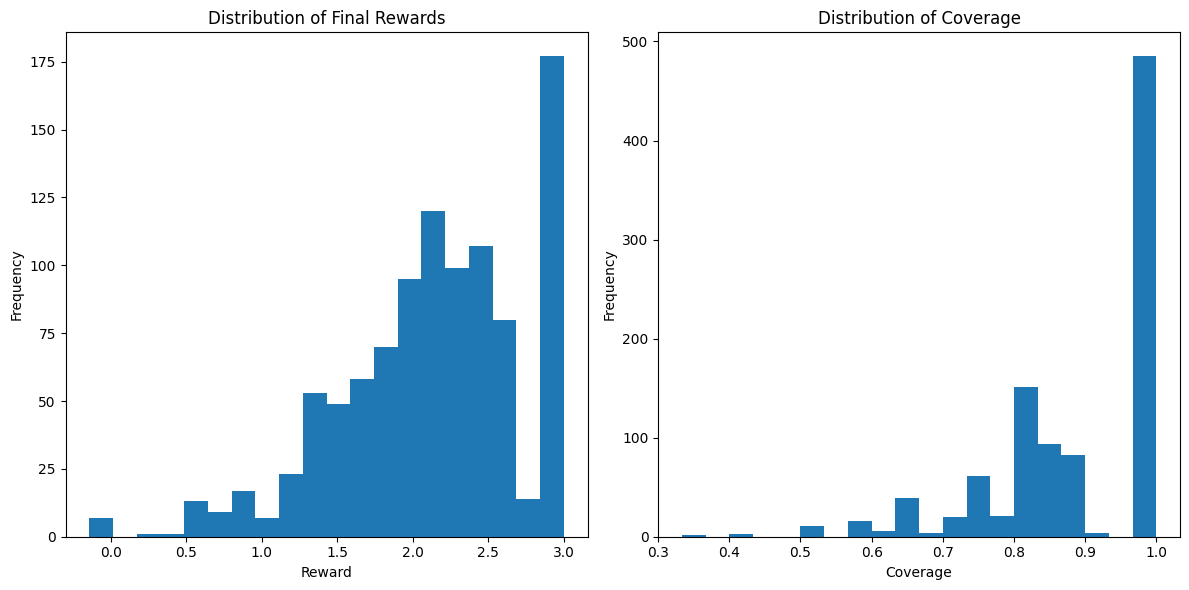

Average Reward: 2.14
Average Coverage: 0.89


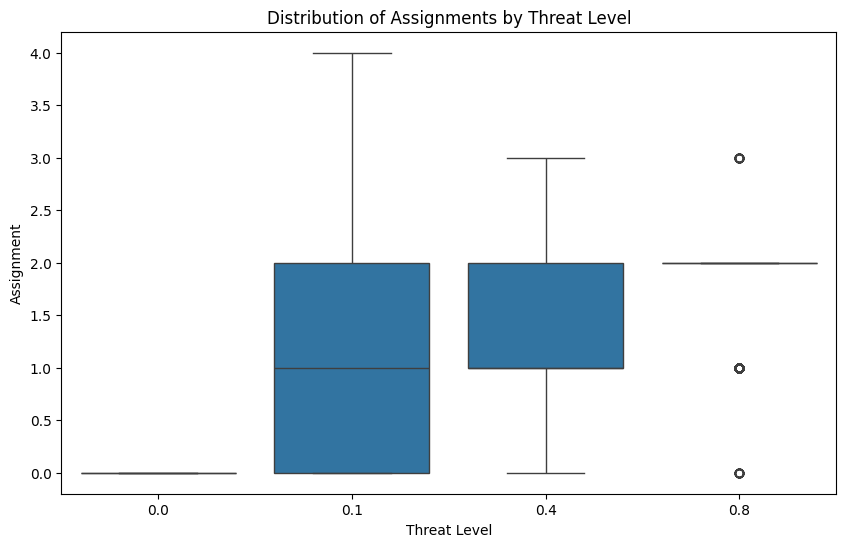

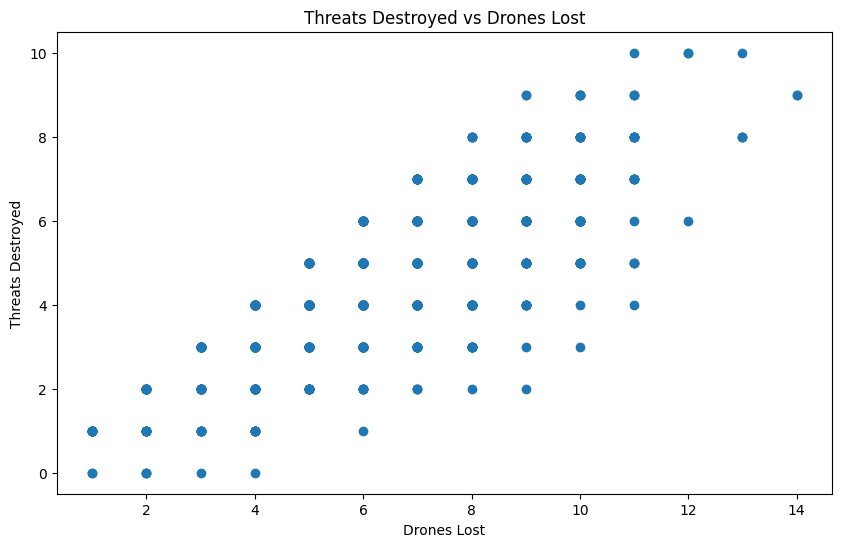

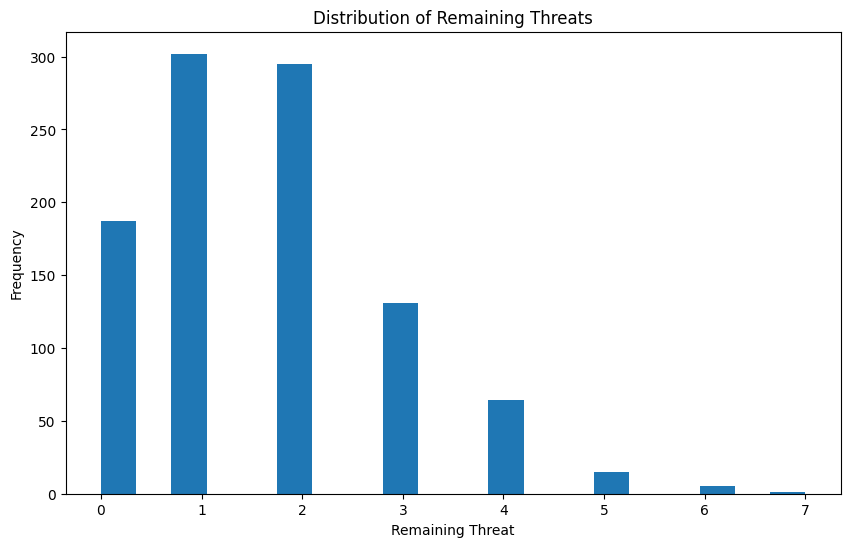

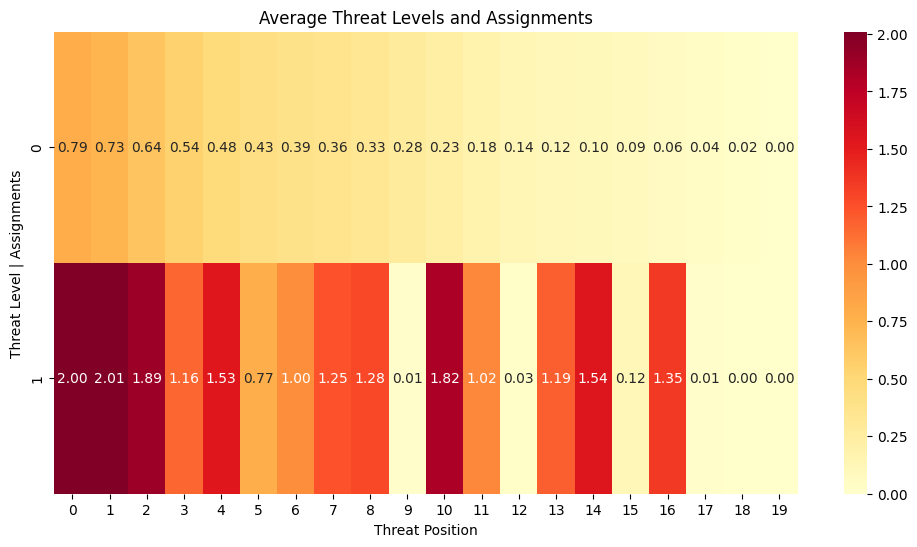

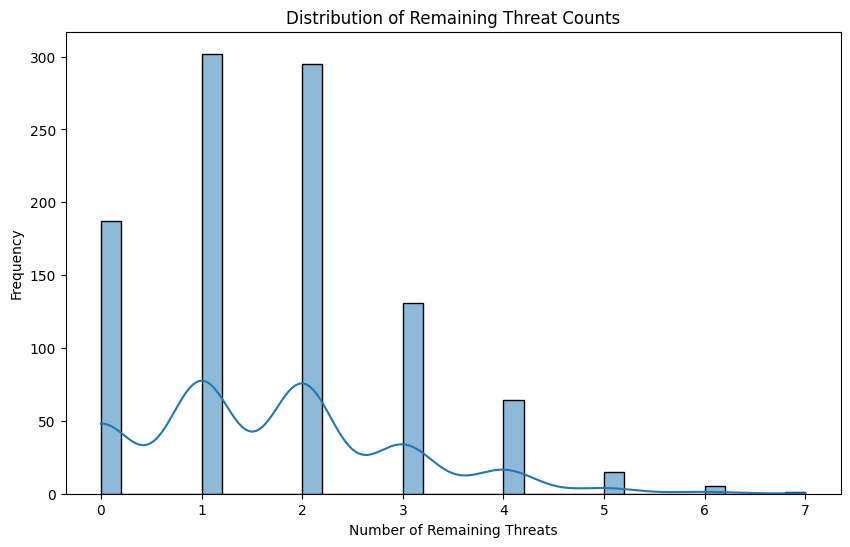

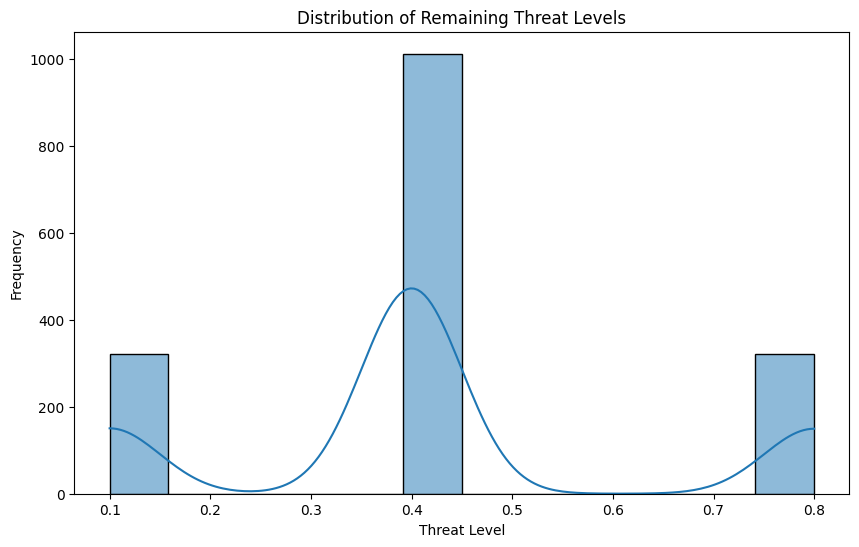

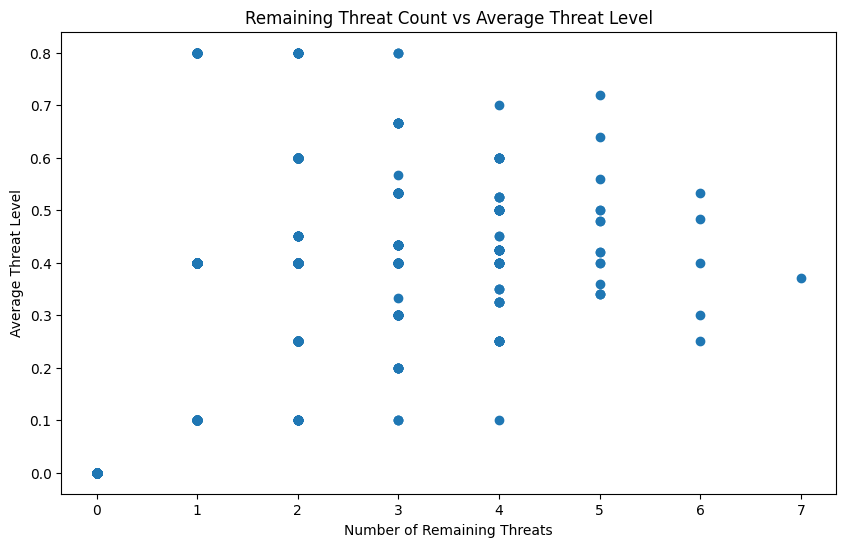

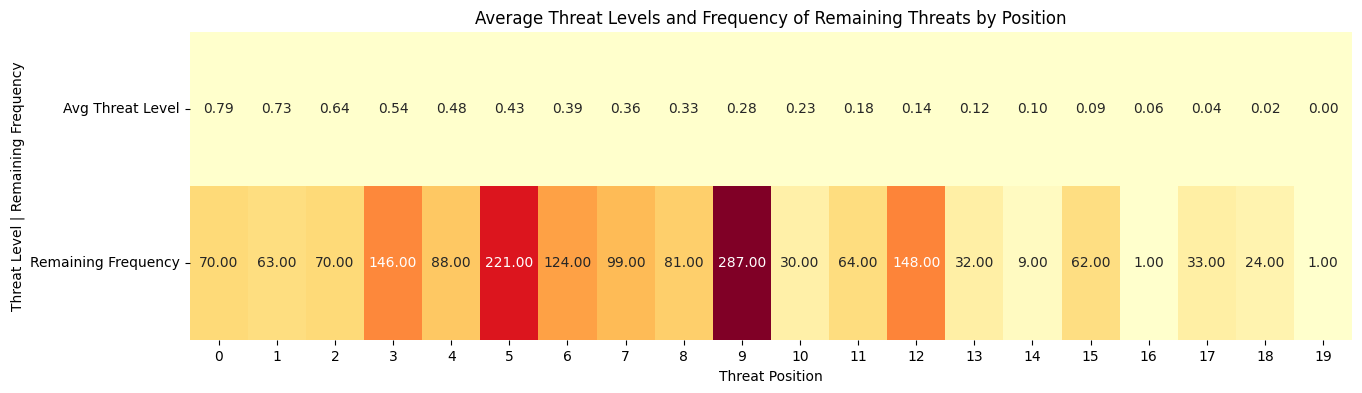

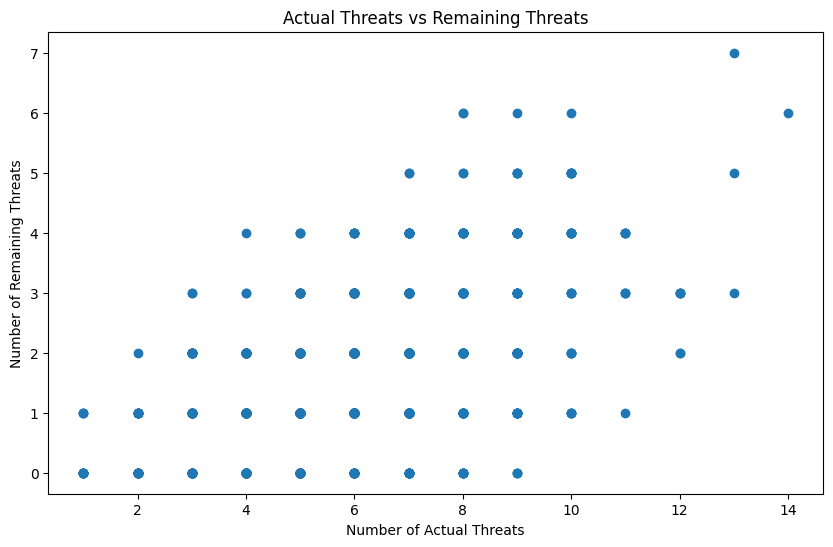

Average Actual Threats: 5.99
Average Remaining Threats: 1.65


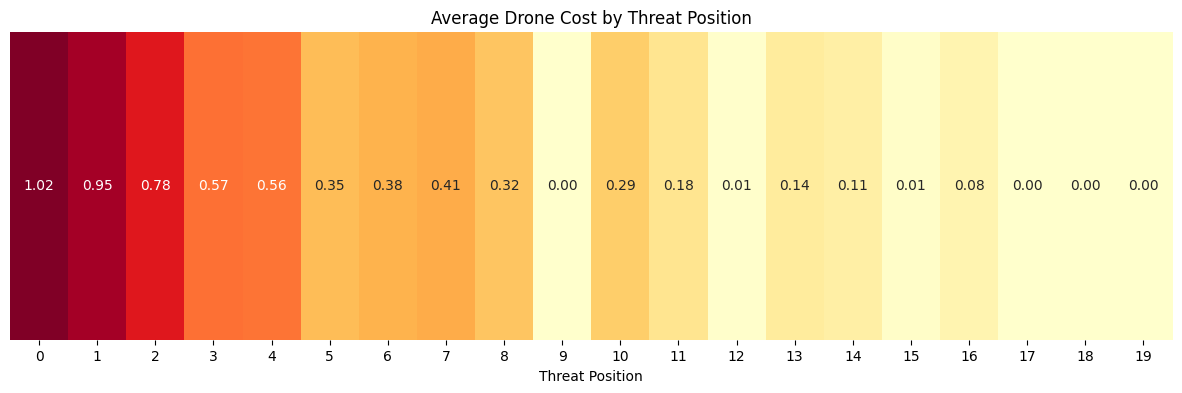

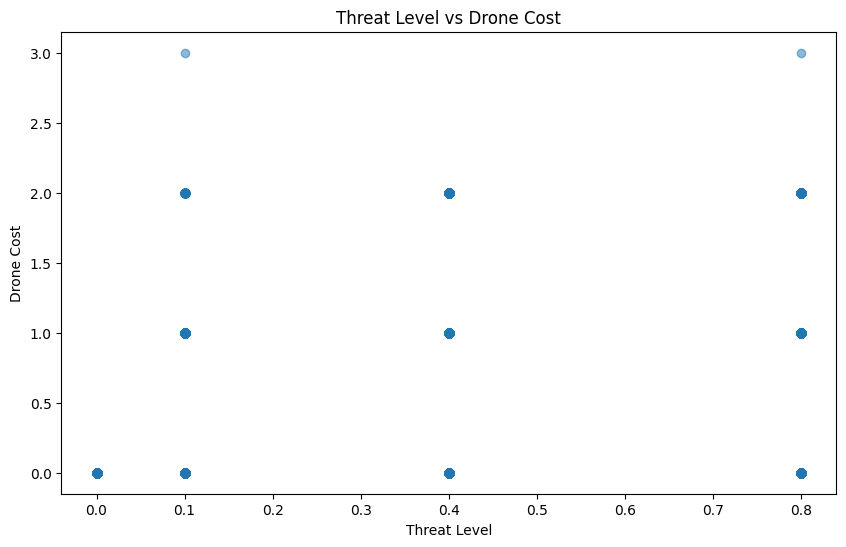

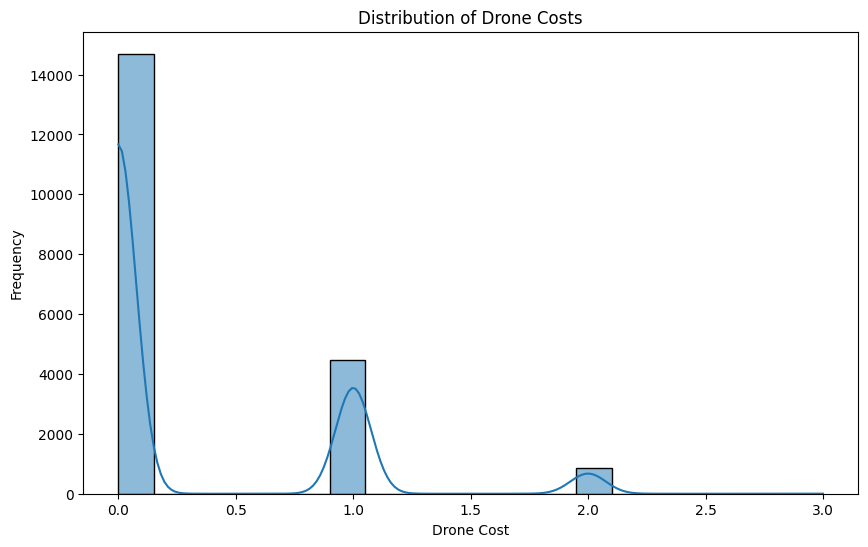

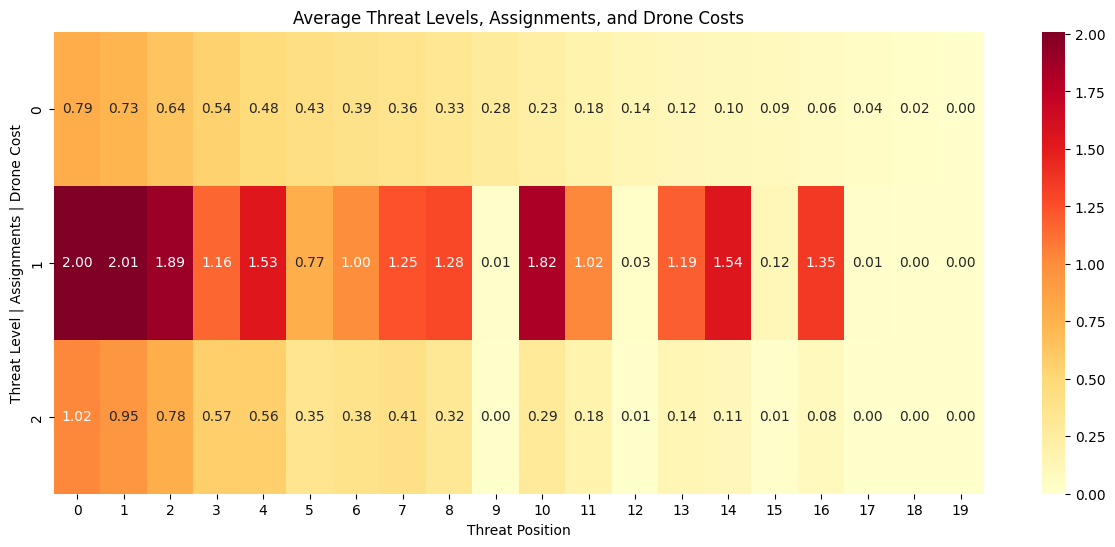

In [7]:
analyze_assignment_strategy(inference_data)

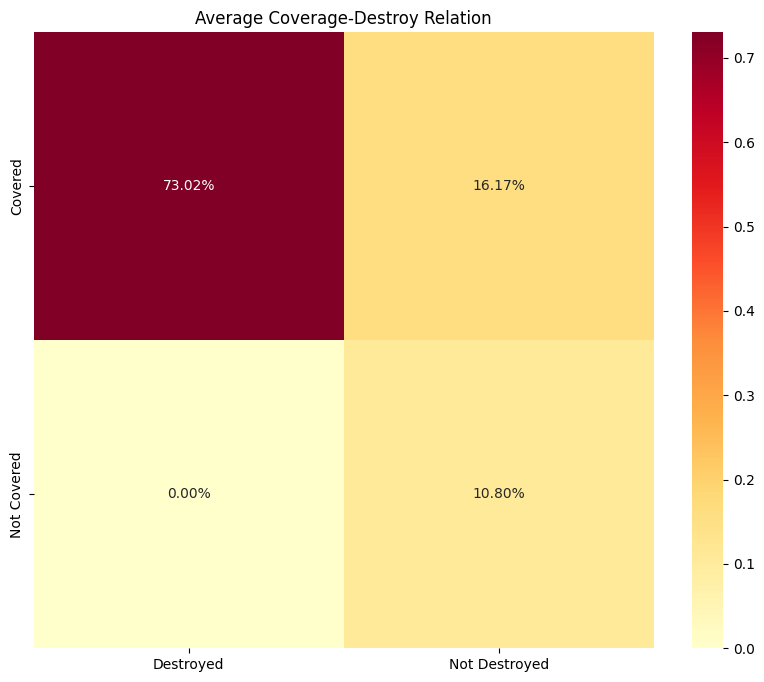

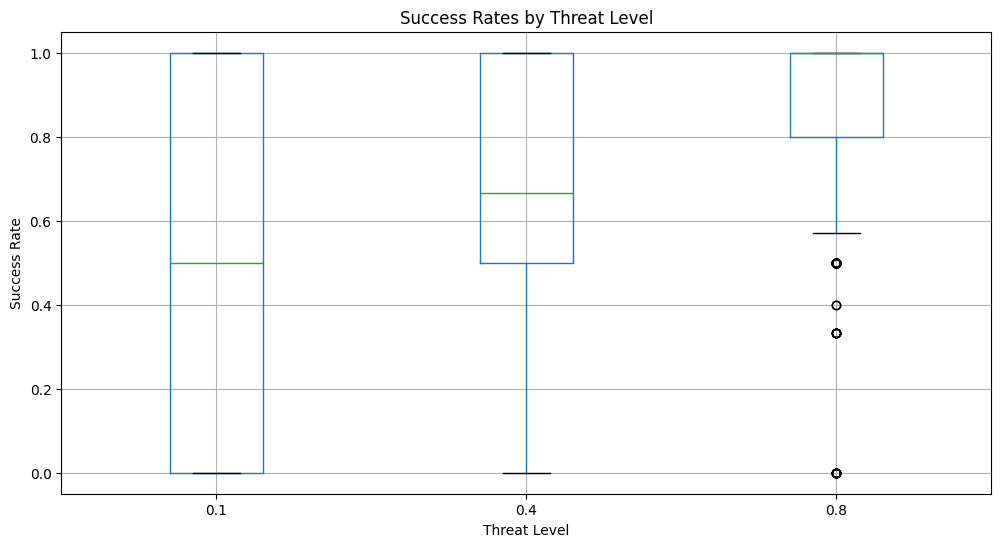

Average Success Rates by Threat Level:
0.0         NaN
0.1    0.550033
0.4    0.653349
0.8    0.886309
dtype: object


In [8]:
analyze_coverage_and_success_rates(inference_data)